# Implementação do Algoritmo de Boosting

Tatiana Santos Camelo de Araujo - 2015086298

## Boosting 

_Boosting_ é um processo que utiliza um conjunto de modelos de solução fraca (_weak learner_) para atingir melhor acurácia e criar uma solução forte (_strong learner_).

Os _weak learners_ no Adaboost são árvores de decisão de primeiro nível, chamados de _stumps_. Na primeira iteração, todos os pesos do algoritmo iniciam iguais e após isso, as decisão classificadas incorretamente passam a ter maior peso do que as classificadas corretamente.

## Implementação

Primeiramente importamos as bibliotecas necessárias. 

In [13]:
import numpy as np
import pandas as pd

from IPython.display import display

import matplotlib.pyplot as plt

%matplotlib inline

Em sequência fazemos a leitura e estruturação dos dados de entrada.

Para isso vamos separar nossos dados em dois grupos, `features` e `labels`. 

| Grupo    | Descrição                  |
| :------- | :------------------------- |
| features | caractetirsticas dos dados |
| labels   | classificação              |

In [14]:
# Open pandas dataframe
data = pd.read_csv('tic-tac-toe.data', header=None).sample(frac=1)

# List of labels and features
original_features = []
original_labels = []

# Labels
original_labels = data[data.columns[9]].values 
del data[data.columns[9]] 
original_labels = pd.Categorical(original_labels).codes
original_labels = [1 if i == 1 else -1 for i in original_labels]
original_labels = np.asarray(original_labels)

# Features
original_features = data.values
original_features = np.asarray(original_features)

Após essa separação podemos imprimir as classes na variavel `labels` para verificar a transformação em dado categórico. 
A escolha para manipulação como valor negativo e positivo se dá por tornar mais intuitivo os valores corrependentes como positivos e negativos, além de possibilitar a troca de valor das classificações incorretas.

In [15]:
display(original_labels)

array([ 1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1, -1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,
       -1, -1,  1,  1, -1,  1,  1,  1,  1, -1,  1, -1, -1,  1,  1, -1,  1,
        1, -1,  1, -1,  1,  1, -1,  1,  1, -1,  1, -1, -1,  1,  1,  1,  1,
        1,  1,  1, -1,  1,  1,  1,  1,  1,  1, -1, -1, -1,  1,  1,  1,  1,
       -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
       -1,  1, -1,  1,  1, -1,  1, -1,  1,  1, -1,  1,  1,  1,  1,  1,  1,
       -1, -1, -1,  1,  1,  1,  1, -1,  1,  1,  1, -1, -1,  1,  1,  1,  1,
       -1,  1,  1,  1, -1,  1,  1, -1,  1, -1,  1, -1,  1,  1,  1,  1,  1,
       -1,  1, -1, -1,  1,  1,  1, -1, -1,  1, -1,  1, -1,  1,  1, -1, -1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1, -1,  1,
        1,  1,  1,  1,  1, -1, -1,  1,  1, -1,  1,  1, -1,  1,  1, -1, -1,
        1, -1, -1,  1,  1,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1, -1,  1,
       -1, -1,  1,  1,  1

##  Classificador - AdaBoost

Uma vez que temos os dados discriminados, agora precisamos do algoritmo de classificação. O Adaboost irá iniciar os atributos da sua classe, calcular predição e erro de cada stump e compará-los para escolher o melhor modelo. Então é feita a comparação e cálculo de acurácia e erro. As escolhas de modelos, acurárias e erros serão aplicadas no boosting.

In [16]:
class AdaBoost:
    """
    Adaboost Classifier
    """

    FEATURES = 'features'
    ATTRIBUTE = 'attribute'
    CLASS = 'class'
    VALUE = 'value'
    STATE = 'state'
    ERROR = 'error'
    PREDICTIONS = 'predictions'
    POSSIBLE_VALUES = ['x', 'o', 'b']
    POSSIBLE_STATES = [1, -1]

    def __init__(self, training_set, testing_set):
        """
        Constructor
        """

        # Class variables
        self.training_set = training_set
        self.testing_set = testing_set
        self.features_len = training_set[self.FEATURES].shape[1]
        self.train_len = training_set[self.FEATURES].shape[0]
        self.test_len = testing_set[self.FEATURES].shape[0]
        self.weights = np.divide(np.ones(self.train_len), self.train_len)
        self.ensemble = []
        self.alpha = []

    def evaluate_stump(self, stump):
        """
        Evaluate stump individualy
        """
        
        # Stump evaluate parameters
        predictions = np.zeros(self.train_len)
        pred_errors = np.ones(self.train_len)

        a = stump[self.ATTRIBUTE]

        # Evaluate stump based on training data
        for i in range(self.train_len):
            value = self.training_set[self.FEATURES][i][a]
            output = self.training_set[self.CLASS][i]

            if value == stump[self.VALUE]:
                predictions[i] = stump[self.STATE]
            else:
                predictions[i] = stump[self.STATE] * -1

            if predictions[i] == output:
                pred_errors[i] = 0

        # Stump error
        error = np.sum(np.multiply(self.weights, pred_errors))
        
        return error, predictions

    def find_best_stump(self):
        """
        Compare stumps and find stump with lowest error
        """
        
        # Inf - higher error for stump compare
        lowest_error = float('inf')

        # Possible values
        possible_values = self.POSSIBLE_VALUES
        possible_states = self.POSSIBLE_STATES

        # Find stump with lowest error
        for a in range(self.features_len):
            for value in possible_values:
                for state in possible_states:
                    stump = {self.ATTRIBUTE: a, self.VALUE: value, self.STATE: state}

                    error, predictions = self.evaluate_stump(stump)
                    
                    stump[self.ERROR] = error
                    stump[self.PREDICTIONS] = predictions
                    
                    if error < lowest_error:
                        lowest_error = error
                        best_stump = stump

        return best_stump

    def evaluate(self):
        """
        Calc accuracy and arror
        """
        
        correct = 0

        # Prediction based on test data
        for i in range(self.test_len):
            H = 0  

            for model in range(len(self.ensemble)):
                a = self.ensemble[model][self.ATTRIBUTE]
                value = self.testing_set[self.FEATURES][i][a]

                if value == self.ensemble[model][self.VALUE]:
                    prediction = self.ensemble[model][self.STATE]
                else:
                    prediction = self.ensemble[model][self.STATE] * -1

                H += self.alpha[model] * prediction

            H = np.sign(H)

            if H == self.testing_set[self.CLASS][i]:
                correct += 1

        # Accuracy and error
        accuracy = (correct / self.test_len) * 100
        error = 100 - accuracy

        return accuracy, error

    def boost(self, num_stumps):
        """
        Redefine alpha weights
        """
        
        models = []
        
        # Redefine weights for each stump
        for i in range(num_stumps):
            best_model = self.find_best_stump()
            
            alpha = 0.5 * np.log((1 - best_model[self.ERROR]) / best_model[self.ERROR])
            self.alpha.append(alpha) 
            self.ensemble.append(best_model)
            
            results = self.evaluate()          
            accuracy = results[0]
            error = results[1]
            models.append(best_model)

            self.weights = np.multiply(self.weights,np.exp(-1 * self.alpha[i] * np.multiply(self.training_set[self.CLASS], best_model[self.PREDICTIONS])))
            self.weights = np.divide(self.weights, np.sum(self.weights))

        return accuracy, error, models

## Classificação dos dados

Rodando o algoritmo com K Folds, estamos definindo que os dados serão utilizados todos (_k_) vezes e em cad auma destas vezes, um diferente set de dados será treino e teste. Esta implementação evita o overfitting e torna o algoritmo mais genérico.

In [17]:
def run(num_boosts):
    FEATURES = 'features'
    CLASS = 'class'

    k = 5

    features = np.array_split(original_features, k)
    labels = np.array_split(original_labels, k)

    accuracies = []
    errors = []

    print('=================================================')
    print('Executando para ' + str(num_boosts) + ' Stumps')


    
    # Exec k fold
    for i in range(k):
        print(('Fold '+str(i+1)).ljust(10), end=" ")

        # Set up test data
        test = {FEATURES: features[i], CLASS: labels[i].astype(int)}

        # Remaining data as training
        remaining_features = np.concatenate(np.delete(features, i))
        remaining_labels = np.concatenate(np.delete(labels, i))

        train = {FEATURES: remaining_features, CLASS: remaining_labels.astype(int)}

        # Instance Classifier
        boosting = AdaBoost(train, test)

        # Exec classifier with X steps
        accuracy,error,models = boosting.boost(num_boosts)

        # Print accuracy and error for each fold
        print('Accuracy: %.2f'%accuracy+'%', end="\t") 
        print('Error: %.2f'%error+'%')
        accuracies.append(accuracy)
        errors.append(error)

    # Find mean accuracy and error and print on notebook
    accuracy = np.divide(np.sum(accuracies), k)
    error = np.divide(np.sum(errors), k)

    print('-------------------------------------------------')
    print('Final'.ljust(10), end=' ')
    print('Accuracy: %.2f'%accuracy+'%', end='\t')
    print('Error: %.2f'%error+'%')
    print('=================================================')
    
    return accuracy

A fim de entender o impacto do número de boostings na implemetação, foi feita uma comparação de acurácia e erro na execussão dos valores de 10, 50, 100, 500 e 1000.

Executando para 10 Stumps
Fold 1     Accuracy: 75.00%	Error: 25.00%
Fold 2     Accuracy: 72.92%	Error: 27.08%
Fold 3     Accuracy: 75.52%	Error: 24.48%
Fold 4     Accuracy: 70.68%	Error: 29.32%
Fold 5     Accuracy: 74.35%	Error: 25.65%
-------------------------------------------------
Final      Accuracy: 73.69%	Error: 26.31%
Executando para 50 Stumps
Fold 1     Accuracy: 82.81%	Error: 17.19%
Fold 2     Accuracy: 79.17%	Error: 20.83%
Fold 3     Accuracy: 84.90%	Error: 15.10%
Fold 4     Accuracy: 79.06%	Error: 20.94%
Fold 5     Accuracy: 85.86%	Error: 14.14%
-------------------------------------------------
Final      Accuracy: 82.36%	Error: 17.64%
Executando para 100 Stumps
Fold 1     Accuracy: 91.15%	Error: 8.85%
Fold 2     Accuracy: 86.98%	Error: 13.02%
Fold 3     Accuracy: 91.15%	Error: 8.85%
Fold 4     Accuracy: 85.86%	Error: 14.14%
Fold 5     Accuracy: 91.10%	Error: 8.90%
-------------------------------------------------
Final      Accuracy: 89.25%	Error: 10.75%
Executando para 50

Text(0.5,0,'Número de Stumps')

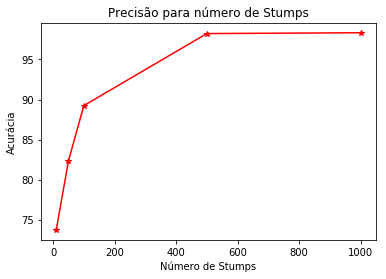

In [18]:
plot_run = []

num_boosts = [10, 50, 100, 500, 1000]

for num in num_boosts:
    plot_run.append(run(num))

plt.title('Precisão para número de Stumps')
plt.plot(num_boosts, plot_run, linestyle='-', marker='*', color='r')
plt.ylabel('Acurácia')
plt.xlabel('Número de Stumps')


A diferenciação entre 500 e 1000 boosts se torna irrelevante. Isto mostra que o algoritmo atingiu a otimização antes de rodar com 1000 bosts. Como há uso de aleatoriedade na dispisição dos dados, é possível achar resultados que saiam um pouco do escopo esperado em execuções.

# Referência

https://machinelearningmastery.com/boosting-and-adaboost-for-machine-learning/